# <div style="text-align: center">18.335/6.337 Problem Set 3 - Orthogonal Triangularization and Projectors</div>
## <div style="text-align: center">Solution</div>
### <div style="text-align: center">Created by Wonseok Shin</div>

$\newcommand{\Cmat}[2]{\mathbb{C}^{#1\times#2}}\newcommand{\Cvec}[1]{\mathbb{C}^{#1}}\newcommand{\Rmat}[2]{\mathbb{R}^{#1\times#2}}\newcommand{\Rvec}[1]{\mathbb{R}^{#1}}\newcommand{\null}{\mathrm{null}}\newcommand{\range}{\mathrm{range}}\newcommand{\rank}{\mathrm{rank}}\newcommand{\nullity}{\mathrm{nullity}}\newcommand{\sign}{\mathrm{sign}}\newcommand{\norm}[1]{\left\|#1\right\|}\newcommand{\abs}[1]{\left|#1\right|}\newcommand{\epsmach}{\epsilon_\mathrm{machine}}\newcommand{\log}{\mathrm{log}}\newcommand{\tanh}{\mathrm{tanh}}\newcommand{\l}{\lambda}\newcommand{\d}{\delta}$

## Problem 1.  Householder QR factorization [5 pts]

(Partly taken from Exercise 10.2 of T&B)

In this problem, we will implement the Householder QR factorization (modification of Alg. 10.1).  In addition, we will implement a function to apply $Q$ or $Q^*$ on a given matrix implicitly (modification of Algs. 10.2 and 10.3).

Continuing our practice from the previous problem set, we will implement these functions in "in-place" style.  For example, we will write the Householder QR factorization such that it triangularizes $A$ into $R$ "in-place" without creating a separate matrix for $R$.  In fact, all the Algs. 10.1–3 in the textbook are written in in-place style.  Remember Julia's convention of [appending `!` to function names](http://docs.julialang.org/en/stable/manual/style-guide/#append-to-names-of-functions-that-modify-their-arguments) for functions modifying the contents of the input arguments.

### Assignment 1.1.  house! [2 pts]

Complete `house!` below that performs the Householder QR factorization described in Alg. 10.1 of T&B.  Unlike Alg. 10.1, the function must handle rank-deficient $A$ as well.

The function takes two input arguments `V` and `A`: 
- `V` is a matrix of the same size as `A`, and
- `A` is square or skinny.

After execution of `house!(V, A)`, 
- the lower-triangular portion of `V` stores the unit vectors $\hat{v}$ used to construct Householder reflectors, i.e., $V_{k:m,k} = \hat{v}_k$, and
- `A` stores the $R$ factor of the full QR factorization of $A$.

Do not create any $m\times n$ matrices inside `house!(V, A)`; avoiding creation of large arrays is the whole purpose of in-place style implementation.

You will receive 1 pt for handling full-rank $A$ correctly, and additional 1 pt for handling rank-deficient $A$ correctly.

In [1]:
function house!(V, A)
    m, n = size(A)
    assert(size(V)==(m,n))

    V .= 0  # initialize

    for k = 1:n
        x = @view A[k:m, k]
        
        # Construct sign(x₁) for exp(iθ) = -sign(x₁).
        s = sign(x[1])
        if s == 0
            s = 1.0
        end

        # Construct the kth Houreholder reflection vector.
        v = @view V[k:m, k]
        copy!(v, x)
        lx = norm(x)
        slx = s * lx
        v[1] += slx
        
        # Perform the Householder reflection to triangularize the kth column of A.
        lv = norm(v)
        if lv ≠ 0
            v ./= lv
            
            # Take care of the kth column of A.
            A[k+1:m, k] .= 0
            A[k,k] = -slx
            
            # Take care of the remaining columns of A.
            if k < n
                A[k:m, k+1:n] .-= v .* (2(v'*@view(A[k:m, k+1:n])))
            end
        end
    end
    
    return nothing
end

house! (generic function with 1 method)

### Validation of your implementation

Use the following code blocks to validate your implementation of `house!`:

In [2]:
# For full-rank A
m, n = 5, 3
A = rand(Complex128, m, n)

R = copy(A)
V = similar(A)

house!(V, R)

println("V lower-triangular?  $(istril(V))")
println("R upper-triangular?  $(istriu(R))")
println()

for j = 1:n
    println("‖V[:,$j]‖ ≈ 1?  $(norm(V[:,j]) ≈ 1)")
end
println()

for j = 1:n
    println("‖A[:,$j]‖ ≈ ‖R[:,$j]‖?  $(norm(A[:,j]) ≈ norm(R[:,j]))")
end

V lower-triangular?  true
R upper-triangular?  true

‖V[:,1]‖ ≈ 1?  true
‖V[:,2]‖ ≈ 1?  true
‖V[:,3]‖ ≈ 1?  true

‖A[:,1]‖ ≈ ‖R[:,1]‖?  true
‖A[:,2]‖ ≈ ‖R[:,2]‖?  true
‖A[:,3]‖ ≈ ‖R[:,3]‖?  true


In [3]:
# For rank-deficient A
A = Float64[
    1 2 3
    1 2 3
    1 2 3
    0 0 3
]

m, n = size(A)

R = copy(A)
V = similar(A)

house!(V, R)

println("V lower-triangular?  $(istril(V))")
println("R upper-triangular?  $(istriu(R))")
println()

println("‖V[:,1‖ ≈ 1?  $(norm(V[:,1]) ≈ 1)")
println("‖V[:,2‖ ≈ 0?  $(norm(V[:,2]) ≈ 0)")
println("‖V[:,3‖ ≈ 1?  $(norm(V[:,3]) ≈ 1)")
println()

for j = 1:n
    println("‖A[:,$j]‖ ≈ ‖R[:,$j]‖?  $(norm(A[:,j]) ≈ norm(R[:,j]))")
end

V lower-triangular?  true
R upper-triangular?  true

‖V[:,1‖ ≈ 1?  true
‖V[:,2‖ ≈ 0?  true
‖V[:,3‖ ≈ 1?  true

‖A[:,1]‖ ≈ ‖R[:,1]‖?  true
‖A[:,2]‖ ≈ ‖R[:,2]‖?  true
‖A[:,3]‖ ≈ ‖R[:,3]‖?  true


In [4]:
R

4×3 Array{Float64,2}:
 -1.73205  -3.4641  -5.19615    
  0.0       0.0     -4.44089e-16
  0.0       0.0      3.0        
  0.0       0.0      0.0        

### Assignment 1.2.  `applyQhouse!` [1 pts]

Complete `applyQhouse!` below that multiplies $Q$ or $Q^*$ implicitly to a given matrix $X$.  The function generalizes the column vector $x$ or $b$ of Algs. 10.2 and 10.3 of T&B to a matrix $X$, so that we can use the function to multiply $Q$ to $R$, which is a matrix, to form $A$.  Also, we will implement Algs. 10.2 and 10.3 in this single function because the two algorithms are very simialr.

The function takes two mandatory input arguments `V` and `X`:
- `V` is populated by `house!`, and
- `X` has the same number of rows as `V` and any number of columns (i.e., $X \in \Cmat{m}{p}$ for $V \in \Cmat{m}{n}$).

In addition, the function takes the third, optional argument `isconj`.  This argument controls which of $Q$ and $Q^*$ to apply: $Q$ for `isconj = false` (the default value), and $Q^*$ otherwise.


After execution of `applyQhouse!(V, X, isconj)`,
- `V` remains the same as before, and
- `X` stores $Q X$ or $Q^* X$ depending on the value of `isconj`.

In [4]:
function applyQhouse!(V, X, isconj=false)
    m, n = size(V)
    assert(size(X,1) == m)

    ks = isconj ? (1:n) : (n:-1:1)  # change application order depending on isconj

    for k = ks
        v = @view V[k:m, k]
        X[k:m,:] .-= v .* (2(v'@view(X[k:m,:])))
    end
    
    return nothing
end

applyQhouse! (generic function with 2 methods)

### Validation of your implementation

Use the following code block to validate you implementation of `applyQhouse!`:

In [5]:
m, n = 10, 7
A = rand(Complex128, m, n)

R = copy(A)
V = similar(A)

house!(V, R)

QR = copy(R)
applyQhouse!(V, QR)
println("QR ≈ A?  $(QR ≈ A)")

Q = eye(Complex128, m)
Qc = eye(Complex128, m)
applyQhouse!(V, Q)
applyQhouse!(V, Qc, true)
println("Qc ≈ Q*?  $(Qc ≈ Q')")
println("Qc Q ≈ I?  $(Qc * Q ≈ eye(m))")

QR ≈ A?  true
Qc ≈ Q*?  true
Qc Q ≈ I?  true


### Assignment 1.3.  `applyQhouse!` vs. direct multiplication of $Q$ [2 pts]

Not producing $Q$ explicitly may seem like one of the disadvantages of the Householder QR factorization compared to the QR factorization based on the Gram–Schmidt procedure.  This is an advantage on the contrary, because `applyQhouse!` is in general a faster way to multiply $Q$ to a vector than direct multiplication of explicitly constructed $Q$.  Let's see why this is the case.

**(a) [1 pt]** Let's compare the costs for the two procedures in terms of the number of flops.  As shown in class, the asymptotic numbers of flops needed for executing `applyQhouse!` and evaluating $Q x$ for a vector $x$ are $2n (2m-n)$ and $2m^2$, respectively.

- How much speedup do you expect to get by using `applyQhouse!(V, x)` instead of $Q x$ for sufficiently large $m$ and $n$?  Answer this question with your speedup factor as a function of $n/m$.  Complete the Julia function `spdup_flop_applyQ(rnm)` below that returns this speedup factor, where `rnm` is the ratio $n/m$.
- In what condition is the speedup factor *minimized* to what value?

***Solution.***

By comparing the numbers of flops required by the two operations, we expect a speedup factor of

$$
\frac{2m^2}{2n(2m-n)} = \frac{1}{\frac{n}{m}\left(2-\frac{n}{m}\right)}
$$

by using `applyQhouse!` instead of $Qx$.

Because $0 < \frac{n}{m} \le 1$, the two factors in the denominator of the above expression are both positive, so we can use the [AM–GM inequality](https://en.wikipedia.org/wiki/Inequality_of_arithmetic_and_geometric_means) to find the maximum of the denominator:

$$
\frac{n}{m}\left(2-\frac{n}{m}\right) \le \left[\frac{\frac{n}{m} + \left(2-\frac{n}{m}\right)}{2}\right]^2 = 1,
$$

where the equality holds when $\frac{n}{m} = 2-\frac{n}{m}$, or $m = n$ equivalently.  Therefore, the speedup factor is minimized to $1$ when $m = n$.


In [6]:
spdup_flop_applyQ(rnm) = 1 / (rnm * (2-rnm))

spdup_flop_applyQ (generic function with 1 method)

**(b) [0.5 pts]** Complete `spdup_time_applyQ` below that measures the speedup factor for a given $V$ by numerical experiment.  
- To measure the actual speedup factor, take the ratio between the times taken for `applyQhouse!` and $Q x$.  (Use `@elapsed`.)
- To perform $Q x$, you will need to construct $Q$ explicitly first using `applyQhouse!`.  
- Because computation time fluctuates wildly from execution to execution, perform $N = 20$ measurments of this ratio and return the median value to ignore outliers.

In [7]:
function spdup_time_applyQ(V, x)
    N = 20
    rt = Vector{Float64}(N)

    # Construct Q explicitly.
    m = size(V, 1)    
    Q = similar(V, (m,m))
    Q .= 0
    Q[diagind(Q)] = 1        
    applyQhouse!(V, Q)
    
    # Perform measurements.
    y = similar(x)
    for k = 1:N
        t_mult = @elapsed A_mul_B!(y, Q, x)
        copy!(y, x)
        t_apply = @elapsed applyQhouse!(V, y)

        rt[k] = t_mult / t_apply
    end
    
    return median(rt)
end    

spdup_time_applyQ (generic function with 1 method)

**(c) [0.5 pts]** The code block below plots the actual speedup factors measured by `spdup_time` for $V \in \Rmat{m}{n}$ with $m = 50$ for $n$ between $1$ and $m$, and compare them with the theoretical speedup factors estimated by `spdup_flop`.  However, you will notice a huge mismatch between the expected theoretical speedup and the actual measurment.  Explain why this is the case.  

Also, modify one line of the code block to fix the mismatch and explain why it fixes the mismatch.

Note: even after the fix, you don't have to get a perfect agreement between the theory and measurment, because 
- our flop estimation is only asymptotic,
- the number of flops is an inaccurate measure of computational cost that does not distinguish different arithmetic operations,
- actual performance depends on not only flops, but also other aspects of computation (e.g., memory bandwidth),
- the measurment overestimates the computation time because it does not exclude the time taken for initialization,

and so on.

***Solution.***

The initial plot produced by the code block below shows that the measured speedup factors are not as great as what we expected from comparing the numbers of flops.  We can suspect that this happens because $Q x$, which is a built-in function of Julia, is a highly optimized piece of code.  Then, each flop in $Q x$ could be much faster than each flop in `applyQhouse!`.  As a result, even though $Q x $ took more flops than `applyQhouse!`, it could take less time.  

Therefore, for a fair comparison between the measurement and theory, we would need to compensate this difference in single flop's execution time.  In other words, we would need to "normalize" the output of `spdup_time` appropriately.

To figure out how to obtain the normalization factor, suppose `applyQhouse!` and `Q*x` take $f(m,n)$ and $g(m,n)$ flops, respectively.  The theoretical speedup factor is then $r_\mathrm{theory}(m,n) = \frac{g(m,n)}{f(m,n)}$.  However, because the code implementing the algorithm for `Q*x` is more optimized than the code implementing the algorithm for `applyQhouse!`, a single flop takes different amounts of time in the two pieces of code.  Suppose that a single flop takes $\alpha$ and $\beta$ seconds in the codes for `applyQhouse!` and `Q*x`, respectively.  Then the measured speedup factor is $r_\mathrm{measurment}(m,n) = \frac{\beta\, g(m,n)}{\alpha\, f(m,n)} = \frac{\beta}{\alpha} r_\mathrm{theory}(m,n)$.  Therefore, to get an agreement between the theoretical and measured speedup factors, we need to divide $r_\mathrm{measurement}(m,n)$ by $\frac{\beta}{\alpha}$.  

$\frac{\beta}{\alpha}$ can be easily obtained by comparing $r_\mathrm{theory}$ and $r_\mathrm{measurement}$ at specific values of $m$ and $n$.  The values we choose is the largest values of $m$ and $n$, because our $r_\mathrm{theory}$ is an asymptotic expression that becomes more accurate for larger $m$ and $n$.  Because $m$ is fixed, the largest $n$ is $n = m$.  Incidentally, from the previous question we know $r_\mathrm{theory} = 1$ for $n = m$. Therefore, $r_\mathrm{measurment}(m,m) = \frac{\beta}{\alpha} r_\mathrm{theory}(m,m) = \frac{\beta}{\alpha}$.  In other words, $\frac{\beta}{\alpha}$ is nothing but $r_\mathrm{measurment}$ measured for $n = m$, which is the last entry of `st` (the output of `stdup_time`) in the code below.

Indeed, dividing each entry of `st` by `st[end]`, we recover an excellent agreement between the theory and measurement as shown below.

An important implication of this result: even though `Q*x` won the speed race against `applyQhouse!`, it did not win the race by defying the required number of flops.  (If it had, we wouldn't have been able to match the two curves so well by simple normalization.)  Therefore, this result demonstrates that the operation count is the fundamental constraint imposed on a given algorithm, and extra speedup of the algorithm can be achieved only by making a single flop faster, not by reducing the operation count.  To reduce the operation count, you need to replace the algorithm (e.g., replace `Q*x` with `applyQhouse!`).

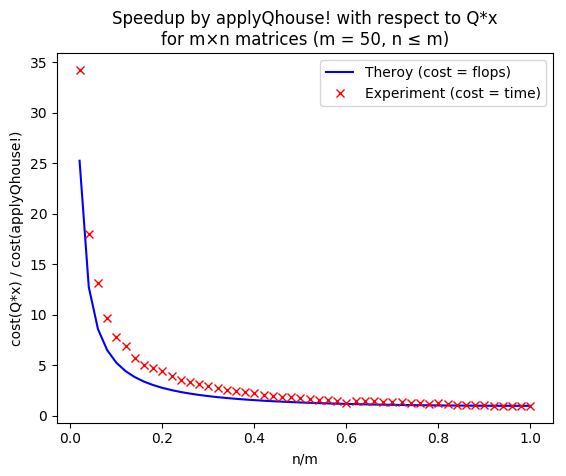

PyObject <matplotlib.legend.Legend object at 0x11f7fc4e0>

In [8]:
m = 50
nmax = m

A = rand(m, nmax)
V = zeros(size(A))
house!(V, A)
x = rand(m)

st = Vector{Float64}(nmax)
for n = 1:nmax
    st[n] = spdup_time_applyQ(@view(V[:,1:n]), x)
end

using PyPlot
rnm = (1:nmax) ./ m

plot(rnm, spdup_flop_applyQ.(rnm), "b-", rnm, st./st[end], "rx")  # change: st -> st./st[end]
title("Speedup by applyQhouse! with respect to Q*x\nfor m×n matrices (m = $m, n ≤ m)")
xlabel("n/m")
ylabel("cost(Q*x) / cost(applyQhouse!)")
legend(["Theroy (cost = flops)", "Experiment (cost = time)"], loc="upper right")

## Problem 2.  Givens QR factorization [3 pts]

The Givens QR factorization is another way to perform the QR factorization.  It is also an orthogonal triangularization method like the Householder QR factorization, but it shines when performing the QR factorization on [upper Hessenberg matrices](https://en.wikipedia.org/wiki/Hessenberg_matrix) as discussed in class.

In this problem. we will implement the Givens QR factorization for $(n+1)\times n$ upper Hessenberg matrices.  Later in this course, we will see a situation where the QR factorization of such upper Hessenberg matrices is needed.  Especially, the upper Hessenberg matrices in that situation will not be given at once, but be constructed gradually by appending columns (i.e., we start with the first column of $H$, and new columns will be appended one-by-one until we have $n$ columns).  The Givens QR factorization implemented in this problem is a version that is applicable to such a situation.

Suppose we have the first $k-1$ columns of an $(n+1)\times n$ upper Hessenberg matrix $H$.  Even though the full matrix is yet to be given, we can still find the $k-1$ Givens rotations that triangularize this partial matrix.  When the $k$th column is appended, we apply these already found $k-1$ rotations to the new column and then find an additional Givens rotation to complete triangularization of the expanded matrix.  By repeating this procedure from $k=1$ to $k = n$, we find the QR factorization of $H$.

The last step of the above procedure is illustrated below for a $5\times4$ upper Hessenberg matrix $H$.  Let's say we have found the 3 Givens rotations $G_1$, $G_2$, $G_3$ that triangularize the first three columns of $H$.  These rotations transform $H_{:,1:3}$ as
$$
H_{:,1:3} = \left[\begin{array}{cccc}
\times & \times & \times \\
\times & \times & \times \\
       & \times & \times \\
       &        & \times \\
       &        &        \\
\end{array}\right]\overset{G_1}{\longrightarrow}
\left[\begin{array}{cccc}
\triangle & \triangle & \triangle \\
       & \triangle & \triangle \\
       & \times & \times \\
       &        & \times \\
       &        &        \\
\end{array}\right]\overset{G_2}{\longrightarrow}
\left[\begin{array}{cccc}
\triangle & \triangle & \triangle \\
       & \square & \square \\
       &        & \square \\
       &        & \times \\
       &        &        \\
\end{array}\right]\overset{G_3}{\longrightarrow}
\left[\begin{array}{cccc}
\triangle & \triangle & \triangle \\
       & \square & \square \\
       &        & \star \\
       &        &        \\
       &        &        \\
\end{array}\right]
$$
Now, the last column $h_4$, indicated by bold entries below, is appended to complete $H$.  If $h_4$ had been present from the start, the Givens rotations $G_1$, $G_2$, $G_3$ that triangularized the first three columns of $H$ would have also transforemd $h_4$ as
$$
H = [H_{:,1:3}\;\; h_4] = \left[\begin{array}{ccccc}
\times & \times & \times & \pmb{\times} \\
\times & \times & \times & \pmb{\times} \\
       & \times & \times & \pmb{\times} \\
       &        & \times & \pmb{\times} \\
       &        &        & \pmb{\times} \\
\end{array}\right]\overset{G_1}{\longrightarrow}
\left[\begin{array}{ccccc}
\triangle & \triangle & \triangle & \pmb{\triangle} \\
       & \triangle & \triangle & \pmb{\triangle} \\
       & \times & \times & \pmb{\times} \\
       &        & \times & \pmb{\times} \\
       &        &        & \pmb{\times} \\
\end{array}\right]\overset{G_2}{\longrightarrow}
\left[\begin{array}{ccccc}
\triangle & \triangle & \triangle & \pmb{\triangle} \\
       & \square & \square & \pmb{\square} \\
       &        & \square & \pmb{\square} \\
       &        & \times & \pmb{\times} \\
       &        &        & \pmb{\times} \\
\end{array}\right]\overset{G_3}{\longrightarrow}
\left[\begin{array}{ccccc}
\triangle & \triangle & \triangle & \pmb{\triangle} \\
       & \square & \square & \pmb{\square} \\
       &        & \star & \pmb{\star} \\
       &        &       & \pmb{\star} \\
       &        &       & \pmb{\times} \\
\end{array}\right]
$$
Therefore, to complete the QR factorization of the full $H$, we just need to apply $G_1$, $G_2$, $G_3$ to the newly appended column $h_4$, and then find and apply one more Givens rotation $G_4$ to take care of the last remaining subdiagonal entry $h_{54}$.



### Assignment 2.1.  `givens_h!` [2 pts]

Considering the above description, complete `givens_h!` below that finds and applies $G_k$ to the newly appended $k$th column of an $(n+1)\times n$ upper Hessenber matrix $H$.

The function takes four input arguments `k`, `c`, `s`, and `h`:

- `k` is the index of the newly appended column of $H$ ($1 \le k \le n$),
- `c` and `s` are length-$n$ vectors whose initial $k-1$ entries are already filled respectively with the cosine and sine factors of $G_1, \ldots, G_{k-1}$, and
- `h` is the newly appended $k$th column $h_k$ of $H$.


After execution of `givens_h!(k, c, s, h)`, 
- the first $k$ entries of `c` and `s` are the cosine and sine factors of $G_1, \ldots, G_k$, and 
- `h` is the $k$th column of the $R$ factor of the QR factorization of $H$.

Once `givens_h!` is completed, the QR factorization of $H$ can be performed simply by applying `givens_h!` to the column $1$ through $n$ of $H$, like the following `givens!` function does:

In [9]:
function givens!(c, s, H)
    m, n = size(H)
    assert(m == n+1)
    
    for k = 1:n
        givens_h!(k, c, s, @view(H[:,k]))
    end
    
    return nothing
end

givens! (generic function with 1 method)

After execution of `givens!(c, s, H)` for length-$n$ vectors $c$ and $s$ and $(n+1)\times n$ upper Hessenberg matrix $H$,

- `c` and `s` respectively store the cosine and sine factors of the Givens rotations $G_1, \ldots, G_n$, and 
- `H` stores the $R$ factor of the QR factorization of originally supplied $H$.

You will receive 1 pt for handling full-rank $H$ correctly, and additional 1 pt for handling rank-deficient $H$ correctly.

In [10]:
function givens_h!(k, c, s, h)
    # Apply the previously constructed Givens rotations to h.
    for i = 1:k-1
        x, y = h[i], h[i+1]
        h[i] = c[i]'*x + s[i]'*y
        h[i+1] = -s[i]*x + c[i]*y
    end

    # Construct a new Givens rotation to nullify the last entry of h.
    x, y = h[k], h[k+1]
    d = hypot(x, y)
    if d == 0  # rank-deficient case
        c[k] = 1
        s[k] = 0
    else
        c[k] = x / d
        s[k] = y / d
    
        # Nullify the last entry of h using the Givens rotation.
        h[k] = c[k]'*x + s[k]'*y
        h[k+1] = 0
    end
    
    return nothing
end

givens_h! (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of `givens_h!`:

In [11]:
# For full-rank H
n = 4
H = rand(Complex128, n+1, n)
H = triu(H, -1)

R = copy(H)
c = similar(H, n)
s = similar(H, n)

givens!(c, s, R)

println("R upper-triangular?  $(istriu(R))")
println()

for j = 1:n
    println("‖H[:,$j]‖ ≈ ‖R[:,$j]‖?  $(norm(H[:,j]) ≈ norm(R[:,j]))")
end

R upper-triangular?  true

‖H[:,1]‖ ≈ ‖R[:,1]‖?  true
‖H[:,2]‖ ≈ ‖R[:,2]‖?  true
‖H[:,3]‖ ≈ ‖R[:,3]‖?  true
‖H[:,4]‖ ≈ ‖R[:,4]‖?  true


In [12]:
# For rank-deficient H
H = Float64[
    1 2 3
    1 2 3
    0 0 3
    0 0 3
]
~, n = size(H)

R = copy(H)
c = similar(H, n)
s = similar(H, n)

givens!(c, s, R)

println("R upper-triangular?  $(istriu(R))")
println()

for j = 1:n
    println("‖H[:,$j]‖ ≈ ‖R[:,$j]‖?  $(norm(H[:,j]) ≈ norm(R[:,j]))")
end

R upper-triangular?  true

‖H[:,1]‖ ≈ ‖R[:,1]‖?  true
‖H[:,2]‖ ≈ ‖R[:,2]‖?  true
‖H[:,3]‖ ≈ ‖R[:,3]‖?  true


### Assignment 2.2.  `applyQgivens!` [1 pt]

Complete `applyQgivens!` below that multiplies $Q$ or $Q^*$ implicitly to a given matrix $X$.

The function takes three mandatory input arguments `c`, `s`, and `X`:
- `c` and `s` are length-$n$ vectors populated by `givens!`, and
- `X` has $n+1$ rows and any number of columns (i.e., $X \in \Cmat{(n+1)}{p}$ for any $p$).

In addition, the function takes the fourth, optional argument `isconj`.  This argument controls which of $Q$ and $Q^*$ to apply: $Q$ for `isconj = false` (the default value), and $Q^*$ otherwise.


After execution of `applyQgivens!(c, s, X, isconj)`,
- `c` and `s` remain the same as before, and
- `X` stores $Q X$ or $Q^* X$ depending on the value of `isconj`.

***Solution.***

The tricky part here compared to `applyQhouse!` is that unlike the Householder reflector $F$, the Givens rotation $G$ is not Hermitian ($F^* = F$ but $G^* \neq G$).  Therefore, when applying $Q$, you do not only have to reverse the order of the rotation matrices $G$, but also have to take the conjugate transpose of them.

In [13]:
function applyQgivens!(c, s, X, isconj=false)
    n = length(c)
    G = similar(c, 2, 2)  # placeholder for Givens rotation
    
    ks = isconj ? (1:n) : (n:-1:1)  # change application order depending on isconj

    for k = ks
        ck, sk = c[k], s[k]
        G[1,1], G[1,2], G[2,1], G[2,2] = isconj ? (ck', sk', -sk, ck) : (ck, -sk', sk, ck')
        X[k:k+1, :] = G * @view(X[k:k+1, :])
    end
    
    return nothing
end

applyQgivens! (generic function with 2 methods)

### Validation of your implementation

Use the following code block to validate your implementation of `applyQgivens!`:

In [14]:
n = 10
m = n+1
H = rand(Complex128, m, n)
H = triu(H, -1)

R = copy(H)
c = similar(H, n)
s = similar(H, n)

givens!(c, s, R)

QR = copy(R)
applyQgivens!(c, s, QR)
println("QR ≈ H?  $(QR ≈ H)")

Q = eye(Complex128, m)
Qc = eye(Complex128, m)
applyQgivens!(c, s, Q)
applyQgivens!(c, s, Qc, true)
println("Qc ≈ Q*?  $(Qc ≈ Q')")
println("Qc Q ≈ I?  $(Qc * Q ≈ eye(m))")

QR ≈ H?  true
Qc ≈ Q*?  true
Qc Q ≈ I?  true


## Problem 3.  Projectors [2 pts]

**(a) [1 pt]** Find all the eigenvalues of an arbitrary projector $P$ and their multiplicities.

***Solution.***

Suppose $\lambda$ is an eigenvalue of a projector $P \in \Cmat{m}{m}$ corresponding to an eigenvector $x$, i.e., $P x = \lambda x$.  Then, because $P^2 = P$, we have
$$
\lambda x = P x = P^2 x = \lambda (P x) = \lambda^2 x.
$$
Because eigenvectors are nonzero, this means $\lambda = \lambda^2$, and thus $\lambda$ is either $1$ or $0$.

Now, observe that
- $P x = 1\cdot x$ for $x \in \range(P)$, and
- $P x = 0\cdot x$ for $x \in \null(P)$.

Therefore, we can choose $\rank(P)$ linearly independent $x$'s such that $P x = 1\cdot x$, and $\null(P)$ linearly independent $x$'s such that $P x = 0\cdot x$.  This means the geometric multiplicities of $\lambda = 1$ and $\lambda = 0$ are at least $\rank(P)$ and $\nullity(P)$, respectively.  Because $\rank(P) + \nullity(P) = m$, the total number of eigenvalues, we have counted all the multiplicities (meaning the algebraic multiplicities are the same as the geometric multiplicities).


**(b) [1 pt]** (Taken from Exercise 6.5 of T&B) Let $P \in \Cmat{m}{m}$ be a nonzero projector.  Show that $\norm{P}_2 \ge 1$, with equality if and only if $P$ is an orthogonal projector.

***Proof.***

By definition, $\norm{P}_2 = \max_{x \neq 0} \frac{\norm{P x}_2}{\norm{x}_2}$.  Because $P \neq 0$, the dimension of $\range(P)$ is at least $1$, so there exists nonzero $z$ in $\range(P)$.  For such $z$, $P z = z$, and thus $\frac{\norm{P z}_2}{\norm{z}_2} = 1$.  Therefore, the maximum of the quotient $\frac{\norm{P x}_2}{\norm{x}_2}$ is at least $1$, which proves $\norm{P}_2 \ge 1$.

To show $\norm{P}_2 = 1$ if $P$ is an orthogonal projector, note that the SVD of an orthogonal projector is written $P = Q \Sigma Q^*$ for a unitary matrix $Q$ and a diagonal matrix $\Sigma$ with only $1$ and $0$ on the diagonal.  Furthermore, $\Sigma$ must have at least one $1$ on the diagonal for $P \neq 0$.  Therefore, $\norm{P}_2 = \sigma_\max(P) = 1$.

Conversely, to show $P$ is an orthogonal projector if $\norm{P}_2 = 1$, suppose that $P \in \Cmat{m}{m}$ is *not* an orthogonal projector.  Our aim is to show that there exists $r \in \Cvec{m}$ whose shadow $P r$ is longer than $r$ for this non-orthogonal projector $P$.  (If you draw an non-orthogonal projector in 2D, you will realize that this claim is pretty obvious.  Still, we need to prove it rigorously.)  This implies $\norm{P}_2 > 1$, which proves by contraposition that $P$ is an orthogonal projector if $\norm{P}_2 = 1$.

For convenience, define the set of shadows $S = \range(P)$ and the set of projection directions $D = \null(P)$.  Because $P$ is not an orthogonal projector, $S$ is not orthogonal to $D$.  However, we can easily find a subspace $D^\bot$ orthogonal to $D$.  ($D^\bot$ is called the [orthogonal complement](https://en.wikipedia.org/wiki/Orthogonal_complement) of $D$.)  Then, we can construct an *orthogonal* projector $R \in \Cmat{m}{m}$ onto $D^\bot$ along $D$.  The two projectors $P$ and $R$ share $D$ as the set of projection directions, but their sets of shadows ($S$ and $D^\bot$) are different.  Note that $\dim(S) = m - \dim(D) = \dim(D^\bot)$.

We know there exists $s \in S$ such that $s \notin D^\bot$.  (If all $s \in S$ satisfy $s \in D^\bot$, then $S = D^\bot$ because $\dim(S) = \dim(D^\bot)$, but this is impossible because $S$ is not orthogonal to $D$.)  For such $s$, consider $r = R s$.  Because $R (r-s) = R^2 s - R s = 0$, we have $r - s \in D$, which implies $P(r - s) = 0$.  Therefore, $P r = P s = s$.  Note that $\norm{R s}_2 < \norm{s}_2$ because $s \notin \range(R)$ for an orthogonal projector $R$.  Therefore, we have found $r$ such that $\norm{r}_2 = \norm{R s}_2 < \norm{s}_2 = \norm{P r}$ as we originally aimed, which completes the proof.

## Bonus Problem.  `formQhouse!` [2 pts]

Above, we used `applyQhouse!` to form $Q$ of the Householder QR factorization explicitly by multiplying $Q$ to $I$ implicitly.  However, it is possible to form $Q$ faster than that.  The goal of this assignment is to create `formQhouse!` that implements this faster method.

**(a) [1 pt]** The second argument $X$ of `applyQhouse!` can be any matrix as long as it has the same number of rows as the first argument $V$.  However, $X = I$ passed to `applyQhouse!` to form $Q$ is not an arbitrary matrix, but a special matrix with a very sparse structure.  

Devise an algorithm that exploits this sparsity of $I$ to form $Q$ faster than naively using `applyQhouse!` on $I$.  Complete `formQhouse!` below that implements this new algorithm.  You do not need to explain your algorithm because the code speaks for itself.

`formQhouse!` takes two input arguments `V` and `Q`:
- `V` is populated by `house!`, and
- `Q` is assumed to be the square identity matrix with the same number of rows as `V` (i.e., $Q = I \in \Cmat{m}{m}$ for $V \in \Cmat{m}{n}$).

After execution of `formQhouse!(V, Q)`,
- `V` remains the same as before, and
- `Q` stores the explicitly formed $Q$ factor of the Householder QR factorization.

***Solution.***

In `applyQhouse!`, $Q X = Q_1 \cdots Q_n X$ is calculated by executing

$$
X_{k:m,:} = X_{k:m,:} - \hat{v}_k (2(\hat{v}_k^* * X_{k:m,:}))
$$

in the order of $k = n, \ldots, 1$.  

`formQ!` also needs to calculate $Q_1 \cdots Q_n X$ using the above formula, but this time $X = I$.  This allows us to replace $X_{k:m,:}$ with $X_{k:m,k:m}$ in the above formula, because starting with $X = I$ ensures $X_{k:m,1:k-1} = 0$ at each step $k$.  For example, for $m = 4$ and $n = 3$, $X$ changes as follows:

$$
\left[\begin{array}{cccc}
1 &   &   &  \\
  & 1 &   &  \\
  &   & 1 &  \\
  &   &   & 1\\
\end{array}\right]\overset{Q_3}{\longrightarrow}
\left[\begin{array}{cccc}
1 &   &   &  \\
  & 1 &   &  \\
  &   & \times & \times\\
  &   & \times & \times\\
\end{array}\right]\overset{Q_2}{\longrightarrow}
\left[\begin{array}{cccc}
1 &   &   &  \\
  & \times & \times & \times\\
  & \times & \times & \times\\
  & \times & \times & \times\\
\end{array}\right]\overset{Q_1}{\longrightarrow}
\left[\begin{array}{cccc}
\times & \times & \times & \times\\
\times & \times & \times & \times\\
\times & \times & \times & \times\\
\times & \times & \times & \times\\
\end{array}\right]
$$

Considering this, `formQhouse!` can be implemented as follows:

In [15]:
function formQhouse!(V, Q)
    m, n = size(V)
    assert(size(Q) == (m,m))
    
    for k = n:-1:1
        v = @view V[k:m,k]
        Q[k:m,k:m] .-= v .* (2(v'@view(Q[k:m,k:m])))
    end
    
    return nothing
end

formQhouse! (generic function with 1 method)

**(b) [0.5 pts]** Now, let's compare the costs for `formQhouse!` and `applyQhouse!` in terms of the number of flops.

- Derive the asymptotic numbers of flops needed for executing `formQhouse!` for $V \in \Rmat{m}{n}$ and `applyQhouse!` for the same $V$ and $X=I \in \Rmat{m}{m}$.  (We consider real matrices here, because we will perform numerical experiments for them later.)  
- How much speedup do you expect to get by using `formQhouse!` instead of `applyQhouse!`?  Answer this question with your speedup factor as a function of $n/m$.  Complete the Julia function `spdup_flop_formQ(rnm)` below that returns this speedup factor, where `rnm` is the ratio $n/m$.
- In what condition is the speedup factor *maximized* to what value?

***Solution.***

For each $k$, for each column $q$ of $Q_{k:m,k:m}$, `formQhouse!` spends

- $m-k+1$ multiplications and $m-k$ additions for $\alpha = \hat{v}_k^* q$,
- $1$ scalar multiplication for $\beta = 2\alpha$, 
- $m-k+1$ multiplications for $w = \hat{v}_k \beta$,
- $m-k+1$ subtractions for $q = q-w$,

which are $4(m-k+1)$ flops in total.  Because $Q_{k:m,k:m}$ has $m-k+1$ columns and $k$ runs from $n$ down to $1$, the total number of flops taken by `formQhouse!` is

$$
\sum_{k=n}^1 4(m-k+1)^2 = \sum_{j=m-n+1}^m 4j^2 \sim \frac{4}{3} \left[m^3 - (m-n)^3\right].
$$

`applyQhouse!` also spends $4(m-k+1)$ flops for each column $x$ of $X_{k:m,:}$ for each $k$.  Because $X = I$, $X_{k:m,:}$ has $m$ colums.  Therefore, the total number of flops taken by `applyQ!` is

$$
\sum_{k=n}^1 4(m-k+1)m = \sum_{j=m-n+1}^m 4mj \sim 2 m \left[m^2 - (m-n)^2\right].
$$

Comparing the two results, we expect a speedup factor of

$$
\frac{2 m \left[m^2 - (m-n)^2\right]}{\frac{4}{3} \left[m^3 - (m-n)^3\right]} = \frac{3}{2} \left[\frac{1 - (1-\frac{n}{m})^2}{1 - (1-\frac{n}{m})^3}\right]
$$

by using `formQhouse!` instead of `applyQhouse!`.

To find out when the speedup factor is maximized, define $s = 1-n/m$.  Then, the above speedup factor satisfies

$$
\frac{3}{2} \left(\frac{1 - s^2}{1 - s^3}\right) = \frac{3}{2} \frac{1 + s}{1 + s + s^2}= \frac{3}{2} \frac{1}{\left[(1 + s) + \frac{1}{1+s}\right] - 1} \le \frac{3}{2} \frac{1}{2 - 1} = 1.5
$$

from the [AM–GM inequality](https://en.wikipedia.org/wiki/Inequality_of_arithmetic_and_geometric_means), and the equality holds when $1 + s = \frac{1}{1+s}$, or $n = m$ equivalently.  Therefore, we get the maximum speedup factor of $1.5$ when $n = m$.

In [16]:
spdup_flop_formQ(rnm) = 1.5 * (1-(1-rnm)^2) / (1-(1-rnm)^3)

spdup_flop_formQ (generic function with 1 method)

**(c) [0.5 pts]** Complete `spdup_time_formQ` below that measures the actual speedup factor for a given $V$ by numerical experiment.  

- To measure the actual speedup factor, take the ratio between the times taken for `formQhouse!` and `applyQhouse!`.  (Use `@elapsed`.)
- Because computation time fluctuates wildly from execution to execution, perform $N = 20$ measurments of this ratio and return the median value to ignore outliers.

You can compare the theoretical speedup factor obtained in Part (b) with the actual measurement by `spdup_time_formQ` using the subsequent code block.  (This time, you don't have to change anything in the code block.)  Again, you don't have to get a perfect agreement between the theory and measurment.

In [17]:
function spdup_time_formQ(V)
    N = 20
    rt = Vector{Float64}(N)

    Q = similar(V, (m,m))
    for k = 1:N
        Q .= 0
        Q[diagind(Q)] = 1
        t_apply = @elapsed applyQhouse!(V, Q)

        Q .= 0
        Q[diagind(Q)] = 1
        t_form = @elapsed formQhouse!(V, Q)
        
        rt[k] = t_apply / t_form
    end
    
    return median(rt)
end

spdup_time_formQ (generic function with 1 method)

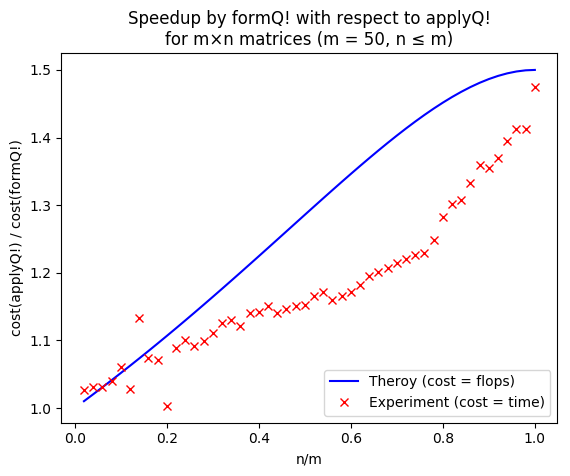

PyObject <matplotlib.legend.Legend object at 0x12df1b908>

In [18]:
m = 50
nmax = m

A = rand(m, nmax)
V = zeros(size(A))
house!(V, A)

st = Vector{Float64}(nmax)
for n = 1:nmax
    st[n] = spdup_time_formQ(@view(V[:,1:n]))
end

using PyPlot
rnm = (1:nmax) ./ m

plot(rnm, spdup_flop_formQ.(rnm), "b-", rnm, st, "rx")
title("Speedup by formQ! with respect to applyQ!\nfor m×n matrices (m = $m, n ≤ m)")
xlabel("n/m")
ylabel("cost(applyQ!) / cost(formQ!)")
legend(["Theroy (cost = flops)", "Experiment (cost = time)"], loc="lower right")